# machine_learning_newton_ring
>牛顿环中心坐标估算主程序

In [1]:
!git clone https://github.com/zerlingx/machine_learning_newton_ring.git

fatal: destination path 'machine_learning_newton_ring' already exists and is not an empty directory.


In [2]:
!cp -r machine_learning_newton_ring/data .

## 00 基本依赖项加载

In [3]:
# 加载依赖项
import cv2
from cv2 import data
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from numpy import random
from numpy.lib.type_check import imag
from easydict import EasyDict as edict
import glob
import os
import time

import mindspore
import mindspore.dataset as ds

import mindspore.dataset.vision.c_transforms as CV
import mindspore.dataset.transforms.c_transforms as C

from mindspore.common import dtype as mstype
from mindspore import context

from mindspore.common.initializer import TruncatedNormal
from mindspore import nn
from mindspore.train import Model
from mindspore.train.callback import Callback
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from mindspore import Tensor
from mindspore.train.serialization import export
from mindspore.ops import operations as P

# 设置MindSpore的执行模式和设备
#context.GRAPH_MODE指向静态图模型，即在运行之前会把全部图建立编译完毕。设备指定为Ascend处理器。
context.set_context(mode=context.GRAPH_MODE, device_target="Ascend")

[WARNING] ME(7392:281473854896432,MainProcess):2021-06-29-11:12:55.317.03 [mindspore/_check_version.py:207] MindSpore version 1.1.1 and "te" wheel package version 1.0 does not match, reference to the match info on: https://www.mindspore.cn/install
MindSpore version 1.1.1 and "topi" wheel package version 0.6.0 does not match, reference to the match info on: https://www.mindspore.cn/install
[WARNING] ME(7392:281473854896432,MainProcess):2021-06-29-11:12:55.621.178 [mindspore/ops/operations/array_ops.py:2302] WARN_DEPRECATED: The usage of Pack is deprecated. Please use Stack.


## 01 数据生成与加载

In [4]:
# 自定义项

# mindspore自定义数据集生成器
class DatasetGenerator:
    def __init__(self):
        img = cv2.imread("data/img/train_img_1.jpg")
        path = "data/img/train_img_"
        for img_i in range(3049):
            img_nxt = cv2.imread(path+str(img_i+2)+".jpg")
            if img_i == 0:
                img = np.stack((img,img_nxt))
            else:
                img_nxt = img_nxt[np.newaxis, :]
                img = np.vstack((img, img_nxt))
        self.image = img
        ct = np.load("data/center/center.npy")
        self.label = ct

    def __getitem__(self, index):
        return self.image[index], self.label[index]

    def __len__(self):
        return len(self.image)

In [5]:
# 生成、加载./data中的数据
dataset_generator = DatasetGenerator()
dataset = ds.GeneratorDataset(dataset_generator, ["image", "label"], shuffle=False)

print("\n01 ---dataset generate complete---\n")

# 全部打印
# for data in dataset.create_dict_iterator():
#     print('{}'.format(data["data"]), '{}'.format(data["label"]))

# 创建数据集的迭代器p_data
# p_data = dataset.create_dict_iterator()


01 ---dataset generate complete---



## 02 数据处理

In [6]:
# 数据处理

# 数据类型转换
type_cast_op_image = C.TypeCast(mstype.float32)
type_cast_op_label = C.TypeCast(mstype.int32)
HWC2CHW = CV.HWC2CHW()
dataset = dataset.map(operations=[type_cast_op_image, HWC2CHW], input_columns="image")
dataset = dataset.map(operations=type_cast_op_label, input_columns="label")
# 归一化
rescale = 1.0 / 255.5
shift = 0
rescale_op = CV.Rescale(rescale, shift)
dataset = dataset.map(input_columns="image", operations=rescale_op)
#打乱顺序
dataset = dataset.shuffle(buffer_size=3050)
#划分数据集
(ds_train,ds_test) = dataset.split([0.8,0.2])
ds_train.input_indexs = [1]
ds_test.input_indexs = [2]
#设置batch_size
#!!!不是分类问题，而且数据集每张的中心坐标label都不一样，batch_size=1
batch_size = 1
ds_train = ds_train.batch(batch_size, drop_remainder=True)
ds_test  = ds_test.batch(batch_size, drop_remainder=True)

[WARNING] ME(7392:281473854896432,MainProcess):2021-06-29-11:17:58.516.098 [mindspore/dataset/engine/datasets.py:855] Dataset is shuffled before split.


测试集大小  2440 组
训练集大小  610 组
(3, 224, 224) [104  95]


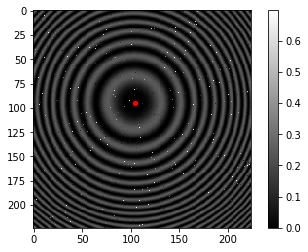

(3, 224, 224) [110  97]


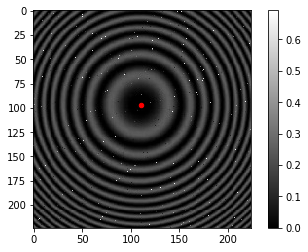

(3, 224, 224) [ 93 113]


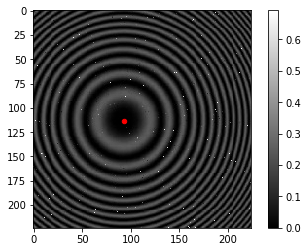


02 ---dataset proceed complete---



In [7]:
print("测试集大小 ",ds_train.get_dataset_size()*batch_size,"组")
print("训练集大小 ",ds_test.get_dataset_size()*batch_size,"组")
# 选三组数据和标签打印，检查是否加载和处理正确
test_p_data = dataset.create_dict_iterator(output_numpy=True)
for i in range(3):
    test_data = next(test_p_data)
    img = test_data["image"]
    ct = test_data["label"]
    print(img.shape, ct)
    plt.imshow(img[0,:], cmap="gray")
    plt.colorbar()
    plt.scatter(int(ct[0]), int(ct[1]), color='r',s=20)
    plt.show()  #打印图像
print("\n02 ---dataset proceed complete---\n")

## 03 模型构建

In [8]:
# 定义模型
class VGG(nn.Cell): 
    # 神经网络的各层需要预先在__init__方法中定义，然后通过定义construct方法来完成神经网络的前向构造
    def __init__(self, num_class=2,channel=3,dropout_ratio=0.7,trun_sigma=0.01):
        super(VGG, self).__init__()
        self.num_class = num_class
        self.channel = channel
        self.dropout_ratio = dropout_ratio
        #设置卷积层
        self.conv11 = nn.Conv2d(self.channel, 64, #224*224*64
                               kernel_size=3, stride=1, 
                               has_bias=True, pad_mode="same",
                               weight_init='xavier_uniform', bias_init='zeros')
        self.conv12 = nn.Conv2d(64, 64,            
                               kernel_size=3, stride=1, 
                               has_bias=True, pad_mode="same",
                               weight_init='xavier_uniform', bias_init='zeros')
        self.conv21 = nn.Conv2d(64, 128, #112*112*128
                               kernel_size=3, stride=1, 
                               has_bias=True, pad_mode="same",
                               weight_init='xavier_uniform', bias_init='zeros')
        self.conv22 = nn.Conv2d(128, 128,
                               kernel_size=3, stride=1, 
                               has_bias=True, pad_mode="same",
                               weight_init='xavier_uniform', bias_init='zeros')
        self.conv31 = nn.Conv2d(128, 256, #56*56*256
                               kernel_size=3, stride=1, 
                               has_bias=True, pad_mode="same",
                               weight_init='xavier_uniform', bias_init='zeros')
        self.conv32 = nn.Conv2d(256, 256,
                               kernel_size=3, stride=1, 
                               has_bias=True, pad_mode="same",
                               weight_init='xavier_uniform', bias_init='zeros')
        self.conv33 = nn.Conv2d(256, 256,
                               kernel_size=3, stride=1, 
                               has_bias=True, pad_mode="same",
                               weight_init='xavier_uniform', bias_init='zeros')
        self.conv41 = nn.Conv2d(256, 512, #28*28*512
                               kernel_size=3, stride=1, 
                               has_bias=True, pad_mode="same",
                               weight_init='xavier_uniform', bias_init='zeros')
        self.conv42 = nn.Conv2d(512, 512,
                               kernel_size=3, stride=1, 
                               has_bias=True, pad_mode="same",
                               weight_init='xavier_uniform', bias_init='zeros')
        self.conv43 = nn.Conv2d(512, 512,
                               kernel_size=3, stride=1, 
                               has_bias=True, pad_mode="same",
                               weight_init='xavier_uniform', bias_init='zeros')
        self.conv51 = nn.Conv2d(512, 512, #14*14*512
                               kernel_size=3, stride=1, 
                               has_bias=True, pad_mode="same",
                               weight_init='xavier_uniform', bias_init='zeros')
        self.conv52 = nn.Conv2d(512, 512,
                               kernel_size=3, stride=1, 
                               has_bias=True, pad_mode="same",
                               weight_init='xavier_uniform', bias_init='zeros')
        self.conv53 = nn.Conv2d(512, 512,
                               kernel_size=3, stride=1, 
                               has_bias=True, pad_mode="same",
                               weight_init='xavier_uniform', bias_init='zeros')
        #设置最大池化层
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.max_pool_mid = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        #设置ReLU激活函数
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(self.dropout_ratio)
        
        self.fc1 = nn.Dense(7*7*512,4096,weight_init=TruncatedNormal(sigma=trun_sigma),bias_init = 0.1)
        self.fc2 = nn.Dense(4096, 4096, weight_init=TruncatedNormal(sigma=trun_sigma), bias_init=0.1)
        self.fc3 = nn.Dense(4096, 1024, weight_init=TruncatedNormal(sigma=trun_sigma), bias_init=0.1)
        self.fc4 = nn.Dense(1024, self.num_class, weight_init=TruncatedNormal(sigma=trun_sigma), bias_init=0.1)
    #构建模型
    def construct(self, x):
        x = self.conv11(x)
        x = self.relu(x)
        x = self.conv12(x)          
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv21(x)
        x = self.relu(x)
        x = self.conv22(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv31(x)
        x = self.relu(x)
        x = self.conv32(x)
        x = self.relu(x)
        x = self.conv33(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv41(x)
        x = self.relu(x)
        x = self.conv42(x)
        x = self.relu(x)
        x = self.conv43(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv51(x)
        x = self.relu(x)
        x = self.conv52(x)
        x = self.relu(x)
        x = self.conv53(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return x
# 构建完成后，可以使用print将神经网络中的各层参数全部打印出来
print(VGG())
print("\n03-1 ---model set complete---\n")

VGG<
  (conv11): Conv2d<input_channels=3, output_channels=64, kernel_size=(3, 3),stride=(1, 1),  pad_mode=same, padding=0, dilation=(1, 1), group=1, has_bias=Trueweight_init=xavier_uniform, bias_init=zeros, format=NCHW>
  (conv12): Conv2d<input_channels=64, output_channels=64, kernel_size=(3, 3),stride=(1, 1),  pad_mode=same, padding=0, dilation=(1, 1), group=1, has_bias=Trueweight_init=xavier_uniform, bias_init=zeros, format=NCHW>
  (conv21): Conv2d<input_channels=64, output_channels=128, kernel_size=(3, 3),stride=(1, 1),  pad_mode=same, padding=0, dilation=(1, 1), group=1, has_bias=Trueweight_init=xavier_uniform, bias_init=zeros, format=NCHW>
  (conv22): Conv2d<input_channels=128, output_channels=128, kernel_size=(3, 3),stride=(1, 1),  pad_mode=same, padding=0, dilation=(1, 1), group=1, has_bias=Trueweight_init=xavier_uniform, bias_init=zeros, format=NCHW>
  (conv31): Conv2d<input_channels=128, output_channels=256, kernel_size=(3, 3),stride=(1, 1),  pad_mode=same, padding=0, dilation

In [9]:
# 定义损失函数（Loss）和优化器（Optimizer）
#loss
net=VGG(num_class=2, channel=3, dropout_ratio=0.5,trun_sigma=0.01)
net_loss = nn.L1Loss(reduction="mean")
#opt
net_opt = nn.Adam(params=net.trainable_params(), learning_rate=0.00001, weight_decay=0.0)
print("\n03-2 ---loss and optimizer set complete---\n")


03-2 ---loss and optimizer set complete---



## 04 开始训练

In [10]:
# 定义回调函数收集模型的损失值和精度值，为之后对训练过程进行可视化显示做准备
class StepLossAccInfo(Callback):
    def __init__(self, model, eval_dataset, steps_loss, steps_eval):
        self.model = model
        self.eval_dataset = eval_dataset
        self.steps_loss = steps_loss
        self.steps_eval = steps_eval

    def step_end(self, run_context):
        cb_params = run_context.original_args()
        cur_epoch = cb_params.cur_epoch_num
        cur_step = (cur_epoch-1)*2400 + cb_params.cur_step_num
        self.steps_loss["loss_value"].append(str(cb_params.net_outputs))
        self.steps_loss["step"].append(str(cur_step))
        if cur_step % 48 == 0:
            acc = self.model.eval(self.eval_dataset, dataset_sink_mode=True)
            self.steps_eval["step"].append(cur_step)
            self.steps_eval["acc"].append(acc["acc"])
            
model = Model(net, loss_fn=net_loss, optimizer=net_opt, metrics={'acc', 'loss'})

time_cb = TimeMonitor()    # 监控每个epoch训练的时间
loss_cb = LossMonitor(per_print_times=ds_train.get_dataset_size())  #LossMonitor用于打印损失函数
# save_checkpoint_steps设置为2400，即每次迭代完成输出一次
config_ck = CheckpointConfig(save_checkpoint_steps=2400,keep_checkpoint_max=10)
ckpoint_cb = ModelCheckpoint(prefix="VGG", directory="./output_model/checkpoint", config=config_ck)

steps_loss = {"step": [], "loss_value": []}
steps_eval = {"step": [], "acc": []}
step_loss_acc_info = StepLossAccInfo(model, ds_test, steps_loss, steps_eval)

print("============== Starting Training ==============")
epoch_size = 20 # 训练次数
# model.train(epoch_size, ds_train, callbacks=[loss_cb, ckpoint_cb, time_cb, step_loss_acc_info], dataset_sink_mode=True)
model.train(epoch_size, ds_train, callbacks=[loss_cb, ckpoint_cb, time_cb], dataset_sink_mode=True)
print('Checkpoints after resuming training:')
print('\n'.join(sorted([x for x in os.listdir("./output_model/checkpoint") if x.startswith('VGG')])))
print("\n04 ---training complete---\n")

============== Starting Training ==============
epoch: 1 step: 2440, loss is 5.4821854
epoch time: 140047.999 ms, per step time: 57.397 ms
epoch: 2 step: 2440, loss is 29.869701
epoch time: 113972.251 ms, per step time: 46.710 ms
epoch: 3 step: 2440, loss is 9.784069
epoch time: 113483.984 ms, per step time: 46.510 ms
epoch: 4 step: 2440, loss is 24.879475
epoch time: 113081.878 ms, per step time: 46.345 ms
epoch: 5 step: 2440, loss is 42.74903
epoch time: 113201.993 ms, per step time: 46.394 ms
epoch: 6 step: 2440, loss is 28.009972
epoch time: 112302.625 ms, per step time: 46.026 ms
epoch: 7 step: 2440, loss is 25.27747
epoch time: 113396.568 ms, per step time: 46.474 ms
epoch: 8 step: 2440, loss is 33.37634
epoch time: 113624.975 ms, per step time: 46.568 ms
epoch: 9 step: 2440, loss is 10.373173
epoch time: 113153.208 ms, per step time: 46.374 ms
epoch: 10 step: 2440, loss is 16.462101
epoch time: 112526.259 ms, per step time: 46.117 ms
epoch: 11 step: 2440, loss is 11.2237625
epoc

## 05 模型分析与使用

In [11]:
# 模型大小
# 统计模型参数量，包括所有可训练的权重、偏置的参数。
params = VGG().trainable_params()
print([(p.name, np.prod(p.data.shape)) for p in params])
num_params = sum([np.prod(p.data.shape) for p in params])
print('Num params(M):', num_params/1e6)

[('conv11.weight', 1728), ('conv11.bias', 64), ('conv12.weight', 36864), ('conv12.bias', 64), ('conv21.weight', 73728), ('conv21.bias', 128), ('conv22.weight', 147456), ('conv22.bias', 128), ('conv31.weight', 294912), ('conv31.bias', 256), ('conv32.weight', 589824), ('conv32.bias', 256), ('conv33.weight', 589824), ('conv33.bias', 256), ('conv41.weight', 1179648), ('conv41.bias', 512), ('conv42.weight', 2359296), ('conv42.bias', 512), ('conv43.weight', 2359296), ('conv43.bias', 512), ('conv51.weight', 2359296), ('conv51.bias', 512), ('conv52.weight', 2359296), ('conv52.bias', 512), ('conv53.weight', 2359296), ('conv53.bias', 512), ('fc1.weight', 102760448), ('fc1.bias', 4096), ('fc2.weight', 16777216), ('fc2.bias', 4096), ('fc3.weight', 4194304), ('fc3.bias', 1024), ('fc4.weight', 2048), ('fc4.bias', 2)]
Num params(M): 138.457922


In [12]:
# 推理时延
x = Tensor(np.ones([1, 3, 224, 224]), mindspore.float32)
net = VGG()
# 预热
for i in range(5):
    y = net(x)
# 多次推理取平均值
start = time.time()
for i in range(100):
    y = net(x)
end = time.time()
print('Latency(ms):', (end-start)/100 * 1000)

Latency(ms): 26.557586193084717


In [15]:
# 加载模型预测 
from mindspore import load_checkpoint
CKPT = './output_model/checkpoint/VGG_2-20_2440.ckpt'
net = net=VGG(num_class=2, channel=3, dropout_ratio=0.5,trun_sigma=0.01)
load_checkpoint(CKPT, net=net)
model = Model(net)

# 从测试集中取出一组样本，输入模型进行预测
p_test = ds_test.create_dict_iterator(output_numpy=True)

第0个sample
预测结果： [[131.87068 132.33084]]   真实结果： [134 134]


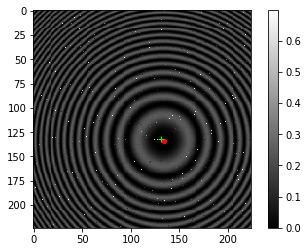

第1个sample
预测结果： [[105.74935 135.1584 ]]   真实结果： [107 136]


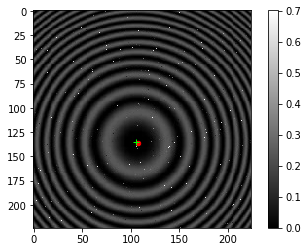

第2个sample
预测结果： [[134.75464 119.26855]]   真实结果： [135 118]


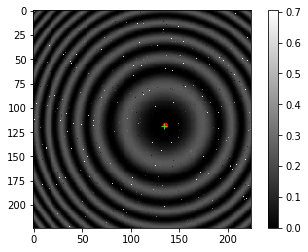

第3个sample
预测结果： [[ 85.91416 113.63705]]   真实结果： [ 85 113]


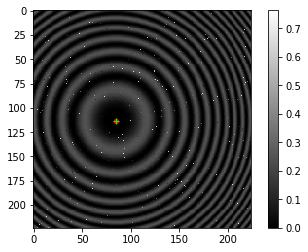

第4个sample
预测结果： [[ 94.40417 102.19857]]   真实结果： [ 93 102]


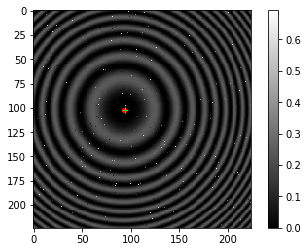

In [20]:
##显示预测结果
for i in range(5):
    # 注意这里每一次next是取出一个dict形式的batch
    test_batch = next(p_test)
    # 从dict里取出数据，注意有batch_size组
    # 但因为batch_size=1，所以每次都要取
    test_image = test_batch["image"]
    test_label = test_batch["label"]
    img = test_image[0]
    ct = test_label[0]
    pre_in = Tensor([img], mindspore.float32)
    pre_ct = model.predict(pre_in)
    pre_ct = pre_ct.asnumpy()
    print("第" + str(i) + "个sample\n预测结果：",  pre_ct, "  真实结果：", ct)
    plt.imshow(img[0,:], cmap="gray")
    plt.colorbar()
    plt.scatter(int(ct[0]), int(ct[1]), color='r',s=20)
    plt.plot(int(pre_ct[0][0]), int(pre_ct[0][1]), marker='+', color='lime')
    plt.show()